# Analyzing the Data

In [1]:
user = %env MONGO_INITDB_ROOT_USERNAME
password = %env MONGO_INITDB_ROOT_PASSWORD
login = user + ":" + password

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
#from pyspark.sql.types import DateType
from pyspark.sql.functions import (month, date_format)

import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder \
                .master('spark://master:7077') \
                .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.11:2.4.0' ) \
                .config("spark.mongodb.input.uri", "mongodb://" + login + "@mongo/power.data?authSource=admin") \
                .config("spark.mongodb.output.uri", "mongodb://" + login + "@mongo/power.results?authSource=admin") \
                .appName("analyze-master") \
                .getOrCreate()

In [4]:
df = spark.read.parquet('hdfs://hadoop:8020/data/power')

In [4]:
df.count()

167926914

In [5]:
df = df.withColumn('Month', date_format(df['DateTime'], 'y-M'))
# df = df.withColumn('day', df['DateTime'].cast('date'))

In [6]:
drop_columns = ['LCLid', 'DateTime' , 'Acorn']
df = df.drop(*drop_columns)

In [ ]:
#df.filter(df['stdorToU'] == 'ToU')
#df.groupBy(['Month', 'stdorToU']).mean()
#df.groupBy(["Month", "Acorn_grouped"]).mean().orderBy(df['Month'])

## Average monthly consumption by group

In [7]:
plot = df.groupBy(["Month", "Acorn_grouped"]).mean().orderBy(df['Month']).toPandas()

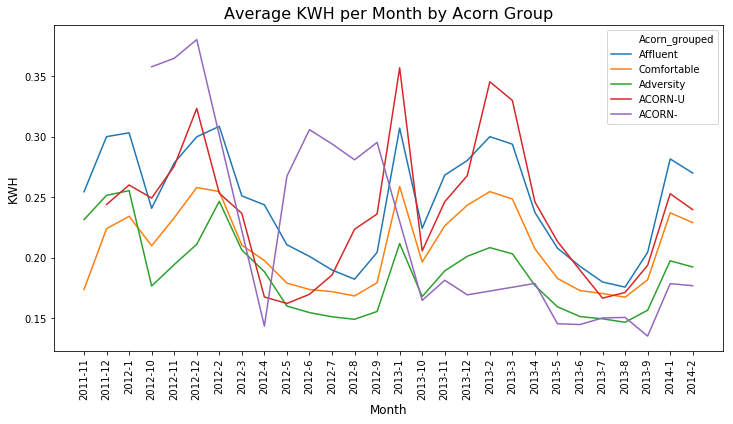

In [8]:
plt.figure(figsize = (12,6))
sns.lineplot(x="Month", y="avg(KWH_per_hh_per_30min)", hue="Acorn_grouped", data=plot)
plt.xticks(rotation=90)
plt.ylabel('KWH', size = 12)
plt.xlabel('Month', size = 12)
plt.title('Average KWH per Month by Acorn Group', size = 16)
plt.savefig('kwh_acorn_group.png')

In [9]:
plot2 = df.groupBy(['Month', 'stdorToU']).mean().orderBy(df['Month']).toPandas()

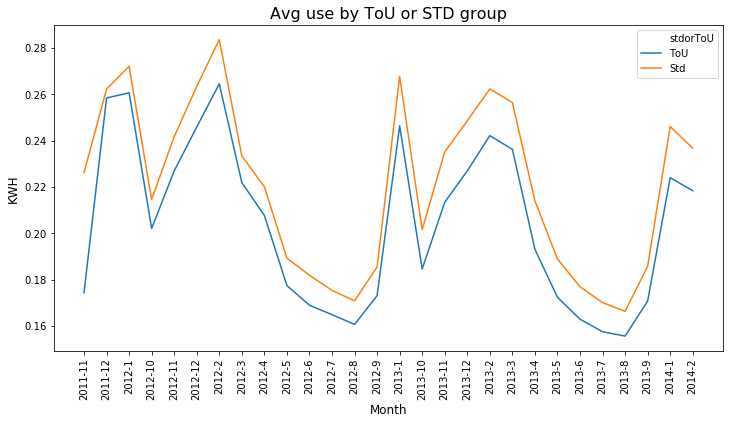

In [10]:
plt.figure(figsize = (12,6))
sns.lineplot(x="Month", y="avg(KWH_per_hh_per_30min)", hue="stdorToU", data=plot2)
plt.xticks(rotation=90)
plt.ylabel('KWH', size = 12)
plt.xlabel('Month', size = 12)
plt.title('Avg use by ToU or STD group', size = 16)
plt.savefig('kwh_std_tou.png')

## Total consumption by Acorn group

In [11]:
df.createOrReplaceTempView('consumption')

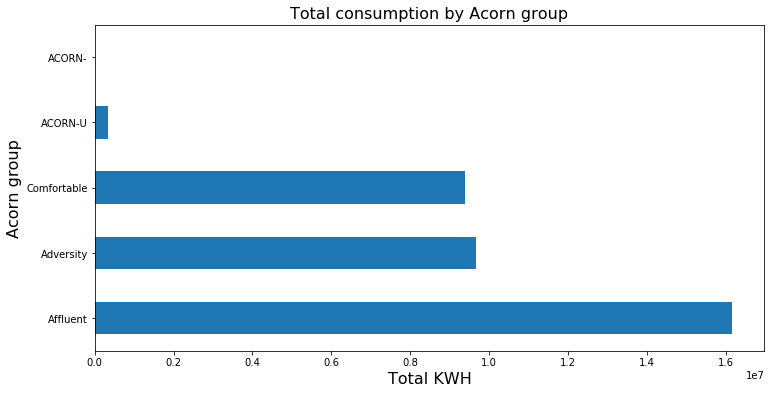

In [12]:
plot3 = spark.sql(
'''
SELECT Acorn_grouped, SUM(KWH_per_hh_per_30min) as TotalKWH
FROM consumption
GROUP BY Acorn_grouped
ORDER BY TotalKWH DESC
'''
).toPandas()

fig,ax = plt.subplots(1,1,figsize=(12,6))
plot3.plot(x = 'Acorn_grouped', y = 'TotalKWH', kind = 'barh', color = 'C0', ax = ax, legend = False)
ax.set_xlabel('Total KWH', size = 16)
ax.set_ylabel('Acorn group', size = 16)
plt.title('Total consumption by Acorn group', size = 16)
plt.savefig('total_consumption.png')
plt.show()

## Average consumption by Acorn group

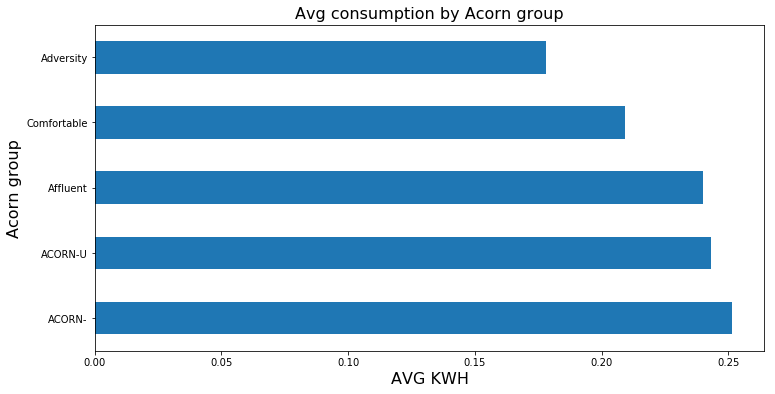

In [13]:
plot4 = spark.sql(
'''
SELECT Acorn_grouped, AVG(KWH_per_hh_per_30min) as AvgKWH
FROM consumption
GROUP BY Acorn_grouped
ORDER BY AvgKWH DESC
'''
).toPandas()

fig,ax = plt.subplots(1,1,figsize=(12,6))
plot4.plot(x = 'Acorn_grouped', y = 'AvgKWH', kind = 'barh', color = 'C0', ax = ax, legend = False)
ax.set_xlabel('AVG KWH', size = 16)
ax.set_ylabel('Acorn group', size = 16)
plt.title('Avg consumption by Acorn group', size = 16)
plt.savefig('avg_consumption.png')
plt.show()

## Total average Consumption by std or ToU

In [14]:
spark.sql(
'''
SELECT stdorToU, AVG(KWH_per_hh_per_30min) as avg_KWH
FROM consumption
GROUP BY stdorToU
ORDER BY avg_KWH DESC
'''
).show()

+--------+-------------------+
|stdorToU|            avg_KWH|
+--------+-------------------+
|     Std|0.21507225601106572|
|     ToU|0.19862264104489252|
+--------+-------------------+



## Average consumption by month by std or ToU
#### python way

In [15]:
df.groupBy(["Month", "stdorToU"]).mean().orderBy(df['Month']).show()

+-------+--------+-------------------------+
|  Month|stdorToU|avg(KWH_per_hh_per_30min)|
+-------+--------+-------------------------+
|2011-11|     Std|       0.2261504085212424|
|2011-11|     ToU|      0.17432714888299897|
|2011-12|     Std|       0.2622466485351527|
|2011-12|     ToU|       0.2583824718207681|
| 2012-1|     Std|      0.27206489998277095|
| 2012-1|     ToU|       0.2606255912460159|
|2012-10|     Std|      0.21455284738171454|
|2012-10|     ToU|       0.2020585416260726|
|2012-11|     ToU|      0.22690432359019744|
|2012-11|     Std|      0.24171974378963448|
|2012-12|     ToU|      0.24585182138328313|
|2012-12|     Std|      0.26337209200730316|
| 2012-2|     ToU|       0.2645090311012442|
| 2012-2|     Std|       0.2836070951519374|
| 2012-3|     Std|       0.2333712014251823|
| 2012-3|     ToU|      0.22187316857930797|
| 2012-4|     Std|       0.2200292909062251|
| 2012-4|     ToU|      0.20766213746141843|
| 2012-5|     Std|       0.1892101496533382|
| 2012-5| 

## Average consumption by month by std or ToU
#### sql method

In [16]:
spark.sql(
'''
SELECT Month, stdorToU, AVG(KWH_per_hh_per_30min) as avg_KWH
FROM consumption
GROUP BY Month, stdorToU
ORDER BY Month DESC
'''
).show()

+------+--------+-------------------+
| Month|stdorToU|            avg_KWH|
+------+--------+-------------------+
|2014-2|     Std|0.23669655507468515|
|2014-2|     ToU|0.21835231193535146|
|2014-1|     Std|0.24605654569799618|
|2014-1|     ToU| 0.2239598979033925|
|2013-9|     Std| 0.1856881813159775|
|2013-9|     ToU|0.17069914215159657|
|2013-8|     ToU|0.15556298701012342|
|2013-8|     Std|  0.166263093455742|
|2013-7|     ToU| 0.1574482858647829|
|2013-7|     Std| 0.1700271878857156|
|2013-6|     Std|0.17687452258238712|
|2013-6|     ToU|0.16286682419652865|
|2013-5|     ToU|0.17231406369198288|
|2013-5|     Std| 0.1888464199283376|
|2013-4|     Std|0.21397607226108656|
|2013-4|     ToU|  0.193024974850236|
|2013-3|     ToU|0.23622334836127548|
|2013-3|     Std|0.25642174069933243|
|2013-2|     ToU| 0.2421388721868845|
|2013-2|     Std|0.26233641855334283|
+------+--------+-------------------+
only showing top 20 rows



## Save results to MongoDB

In [17]:
results = spark.sql(
'''
SELECT Month, stdorToU, AVG(KWH_per_hh_per_30min) as avg_KWH
FROM consumption
GROUP BY Month, stdorToU
ORDER BY Month DESC
'''
)

In [10]:
# save to a different db and coll. must specify uri in config!
results.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("database", 
                                                                                  "power").option("collection", "results").save()